# EFIMM0142: Modelling Analytics
> Group Assignment - Site Selection

### Name & Student Number:

<pre> Jai Pratap Singh (2610966) </pre>
<pre> Jiahui Xu(2557737) </pre>
<pre> Sigao Li(2638795) </pre>
<pre> Maiqi Huang(2524041) </pre>
<pre> Manas Mondal(2520054) </pre>
<pre> Pranjal Sahu(2614672) </pre>
<pre> Pratik Nandeshwar(2636386) </pre>

## Import Libraries & Datasets

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import os
from shapely.geometry import Point, Polygon, MultiPolygon
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary, LpStatus
from tqdm import tqdm
from matplotlib.lines import Line2D

from IPython.display import display
import uuid
import numpy as np
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Read the shapefiles
pop = gpd.read_file("Data/Population_by_Output_Area_2022/Population_estimates_by_single_year_of_age_and_sex_by_Output_Area.shp")
charging_points = gpd.read_file("Data/Electric_Vehicle_Charging_Points_2024/Electric_vehicle_charging_points_NCR.shp")
parking_points = gpd.read_file("Data/Designated_Car_Parks_2024/Designated_car_parks.shp")
life_style = gpd.read_file("Data/Quality_of_Life_2018/Quality_of_Life_2017_to_2018_(ward).shp")

In [3]:
# Read csv file
ev_ownership = pd.read_csv("Data/Electric_Vehicle_Ownership_2021/electricvehicles_2021.csv")

### Population

In [4]:
print(pop.crs)
pop.head()

EPSG:27700


,OBJECTID,OA21_CODE,LSOA21_COD,LSOA21_ONS,LSOA21_LOC,MSOA21_COD,MSOA21_ONS,MSOA21_LOC,WARD_CODE_,WARD_NAME_,...,FEMALE84,FEMALE85,FEMALE86,FEMALE87,FEMALE88,FEMALE89,FEMALE90,ShapeSTAre,ShapeSTLen,geometry
0,1,E00073143,E01014485,Bristol 058A,Mina Road,E02006949,Bristol 058,St Werburghs,E05010885,Ashley,...,0,0,0,0,0,1,0,22856.058451,682.209695,"POLYGON ((360354.402 174607.970, 360375.000 17..."
1,2,E00073145,E01033366,Bristol 059B,St Pauls Grosvenor Road,E02006950,Bristol 059,St Pauls,E05010885,Ashley,...,0,0,0,0,1,0,0,19121.099783,796.829556,"POLYGON ((359385.170 174086.827, 359477.689 17..."
2,3,E00073147,E01014486,Bristol 058C,St Agnes,E02006949,Bristol 058,St Werburghs,E05010885,Ashley,...,2,2,0,0,0,0,0,63607.163768,1454.514983,"POLYGON ((359806.251 174231.617, 359857.141 17..."
3,4,E00073148,E01033348,Bristol 059C,St Pauls City Road,E02006950,Bristol 059,St Pauls,E05010885,Ashley,...,0,0,0,0,0,0,0,22775.678644,709.041606,"POLYGON ((359297.173 174014.188, 359314.361 17..."
4,5,E00073150,E01014486,Bristol 058C,St Agnes,E02006949,Bristol 058,St Werburghs,E05010885,Ashley,...,1,0,0,0,0,0,0,51775.929354,1409.806224,"POLYGON ((359998.549 174309.475, 359992.265 17..."


### Charging Points

In [5]:
print(charging_points.crs)
charging_points.head()

EPSG:27700


,OBJECTID,DeviceId,DeviceRef,DeviceName,DeviceText,SubBuildin,BuildingNa,BuildingNu,Thoroughfa,Street,...,PhysRest_1,OnStreet,LocationTy,Bearing,Access24Ho,Easting,Northing,Latitude,Longitude,geometry
0,1,50dd7100bcbd98c41b1179143a2325a4,PP-12614,Nissan Wessex Bristol,None,None,None,None,Frome Valley Walkway,None,...,None,Yes,Other,None,Yes,359275.202947,174086.617293,51.464275,-2.587624,POINT (359275.203 174086.617)
1,2,f1d32765fb6215ed9ba20bd9e59733b8,PP-5112289,Charlotte Street Car Park 1,None,None,Charlotte Street Car Park,9,Charlotte Street,None,...,None,Yes,Other,None,Yes,374568.715939,165016.839934,51.383620,-2.366824,POINT (374568.716 165016.840)
2,3,492976d6fcdd5205b1ddf77458d42a39,PP-12791,Charlotte Street Car Park 2,None,None,None,9,Charlotte Street,None,...,None,Yes,Other,None,Yes,374559.182147,165016.887792,51.383620,-2.366961,POINT (374559.182 165016.888)
3,4,df952959a69bbc4cf649113a7cc59cd6,PP-5112218,Motability Bristol,None,None,None,None,None,"Bristol Park House, 610 Bristol Business Park,...",...,None,Yes,Other,None,Yes,362384.850082,178209.164724,51.501557,-2.543303,POINT (362384.850 178209.165)
4,5,1a534df4ec7023f89613a24be21a149f,PP-5112351,Odd Down Park & Ride 2,None,None,Odd Down Park and Ride,None,Combe Hay Lane,None,...,None,Yes,Other,None,Yes,373304.345834,161438.720183,51.351389,-2.384722,POINT (373304.346 161438.720)


### Candidate Points

In [6]:
print(parking_points.crs)
parking_points.head()

EPSG:27700


,OBJECTID,BLOCK_NAME,geometry
0,1,Ashmead House,POINT (361025.747 173050.669)
1,2,Barton House,POINT (361129.157 172935.717)
2,3,Barton House,POINT (361138.495 172905.109)
3,4,Beaufort House,POINT (360935.286 173129.447)
4,5,Eccleston House,POINT (361008.420 172922.921)


### Life Style

In [7]:
print(life_style.crs)
life_style.head()

EPSG:3857


,FID,indicator_,indicator,theme,theme_indi,ward_code,ward_name,survey_que,sample_siz,statistic,standard_e,lower_conf,upper_conf,Shape__Are,Shape__Len,geometry
0,1,IQOL17104,% children aged 7 to 10 who travel to school u...,Transport,Transport/% children aged 7 to 10 who travel t...,E05010915,Stockwood,Q17077 Q17078,None,0.000000,0.000000,0.000000,0.000000,8.337309e+06,13499.892964,"POLYGON ((-285412.801 6697286.322, -285390.183..."
1,2,IQOL17045,% who think domestic abuse doesn't really happ...,Crime & Safety,Crime & Safety/% who think domestic abuse does...,E05010916,Stoke Bishop,Q17026,111,11.243311,4.123331,5.335363,22.161712,1.476445e+07,17736.962202,"POLYGON ((-295983.727 6707371.054, -295714.032..."
2,3,IQOL17146,% shift workers who had no other alternatives ...,Employment,Employment/% shift workers who had no other al...,E05010916,Stoke Bishop,Q17107 Q17109,None,0.000000,0.000000,0.000000,0.000000,1.476445e+07,17736.962202,"POLYGON ((-295983.727 6707371.054, -295714.032..."
3,4,IQOL17010,"% who think noise from pubs, clubs and enterta...",Community & Living,Community & Living/% who think noise from pubs...,E05010917,Westbury-on-Trym & Henleaze,Q17010,176,2.566639,1.014920,1.175065,5.514233,1.353607e+07,19550.462286,"POLYGON ((-291181.838 6710660.102, -291193.375..."
4,5,IQOL17017,% who help out their neighbours,Community & Living,Community & Living/% who help out their neighb...,E05010917,Westbury-on-Trym & Henleaze,Q17016,185,39.282256,3.868246,32.009412,47.063712,1.353607e+07,19550.462286,"POLYGON ((-291181.838 6710660.102, -291193.375..."


In [8]:
# Convert the life style to the CRS of the population data
life_style = life_style.to_crs(epsg=27700)
print(life_style.crs)

EPSG:27700


### Proportion of Electric Vehicles

In [9]:
ev_ownership.head()

,per_type,age_16_29,age_30_49,age_50_69,age_over_70
0,car_owner,0.35,0.70,0.75,0.74
1,hybrid,0.00,0.02,0.03,0.02
2,electric,0.04,0.03,0.03,0.02


### Road Network

In [10]:
# Define the place name for Bristol, UK
place_name = "Bristol, United Kingdom"

# Download the road network for Bristol
bristol_road_network = ox.graph_from_place(place_name, network_type='all')
print(bristol_road_network.graph['crs'])

epsg:4326


In [11]:
# Convert the road network to the CRS of the population data
bristol_road_network = ox.project_graph(bristol_road_network, to_crs='epsg:27700')
print(bristol_road_network.graph['crs'])

epsg:27700


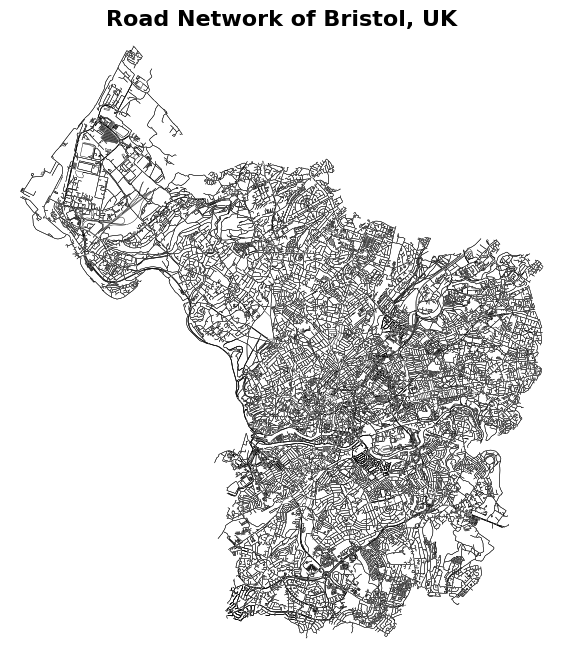

In [12]:
# Plot the road network with title
fig, ax = ox.plot_graph(
    bristol_road_network, 
    node_size=0.1, 
    edge_color='black', 
    edge_linewidth=0.3, 
    bgcolor='white',
    show=False,
    close=False
)

# Add a title
ax.set_title("Road Network of Bristol, UK", fontsize=16, fontweight='bold')

# Display the plot
plt.show()

### Boundary

In [13]:
# Merge all regions of the GeoDataFrame `pop` to create a single boundary
boundary = pop.unary_union
boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs=pop.crs)
print(boundary_gdf.crs)

EPSG:27700


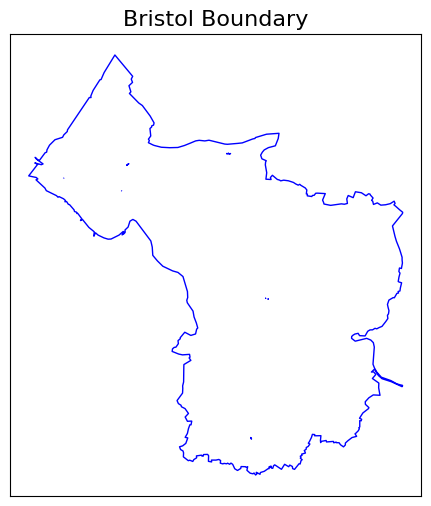

In [14]:
# Plot the boundary using matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
boundary_gdf.plot(ax=ax, edgecolor='blue', linewidth=1, facecolor='none')

# Customize the plot with a title and grid
ax.set_title("Bristol Boundary", fontsize=16)
ax.grid(True)

# Remove x and y labels
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [15]:
# # check how many nodes and edges in the graph
# print(f"Number of nodes: {len(bristol_road_network)}")

# # check if the network is a directed graph
# print(f"Is the graph directed? {nx.is_directed(bristol_road_network)}")

In [16]:
# # change the graph to an undirected graph
# bristol_road_network = bristol_road_network.to_undirected()

# # check if the network is fully connected
# print(f"Is the graph fully connected? {nx.is_connected(bristol_road_network)}")

## Part 1: Data Cleaning

### Filter Points Within the Boundary

In [17]:
# Crop `charging_points` to retain only points within the boundary
charging_points = charging_points[charging_points.within(boundary)]
charging_points

,OBJECTID,DeviceId,DeviceRef,DeviceName,DeviceText,SubBuildin,BuildingNa,BuildingNu,Thoroughfa,Street,...,PhysRest_1,OnStreet,LocationTy,Bearing,Access24Ho,Easting,Northing,Latitude,Longitude,geometry
0,1,50dd7100bcbd98c41b1179143a2325a4,PP-12614,Nissan Wessex Bristol,None,None,None,None,Frome Valley Walkway,None,...,None,Yes,Other,None,Yes,359275.202947,174086.617293,51.464275,-2.587624,POINT (359275.203 174086.617)
6,7,7b5fb650c7bca123d83dd9cf7f7f9bca,PP-5112282,Wessex Garages Bristol,None,None,None,None,None,"Pennywell Road, Bristol",...,None,Yes,Other,None,Yes,360063.270369,174032.635441,51.463846,-2.576274,POINT (360063.270 174032.635)
14,15,88692f34e175f423ac0ebf267c158e2e,60401/02 /48/49,Trenchard Street Car Park 1,Car Park,None,None,18,Trenchard Street,Lodge Street,...,None,No,Public car park,None,No,358430.923579,173060.818489,51.454990,-2.599656,POINT (358430.924 173060.818)
15,16,16644a3ed5102e32e7fa6cfb3fd5d00a,60408/42/43/40/41,West End Car Park 1,Car Park,None,None,None,Berkeley Place,Jacobs Wells Road,...,None,No,Public car park,None,No,357757.356333,173146.242343,51.455708,-2.609360,POINT (357757.356 173146.242)
16,17,b4382895819caad3a3cdb580eff83351,60444 / 60445,Temple Gate Car Park 2,Car Park,None,None,None,Chatterton Square,Temple Gate,...,None,No,Public car park,None,No,359496.510722,172295.122202,51.448183,-2.584233,POINT (359496.511 172295.122)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,397,4bef728cf44f6ee697114649e80ae191,GBBPCE615451,DTM Ltd (Bosch service place),None,None,None,None,None,"DTM Ltd (Bosch service place), Short Street S",...,None,No,Other,None,No,360473.366789,172333.453775,51.448597,-2.570181,POINT (360473.367 172333.454)
398,399,351345f28c627ecce65526fd115467f7,GBBPCE1093432,Hilton Garden Inn,None,None,None,None,None,"Hilton Garden Inn, Temple way",...,None,No,Other,None,No,359473.733034,172725.278829,51.452049,-2.584610,POINT (359473.733 172725.279)
399,400,77195c4e029ba71a2e914ba4f867274e,GBBPCE923811,Hilton Garden Inn,None,None,None,None,None,"Hilton Garden Inn, Temple way",...,None,No,Other,None,No,359473.733034,172725.278829,51.452049,-2.584610,POINT (359473.733 172725.279)
400,401,597dd91e6b177f393877f173f231593f,GBBPCE923812,Hilton Garden Inn,None,None,None,None,None,"Hilton Garden Inn, Temple way",...,None,No,Other,None,No,359473.733034,172725.278829,51.452049,-2.584610,POINT (359473.733 172725.279)


In [18]:
# Crop `parking_points` to retain only points within the boundary
parking_points = parking_points[parking_points.within(boundary)]
parking_points

,OBJECTID,BLOCK_NAME,geometry
0,1,Ashmead House,POINT (361025.747 173050.669)
1,2,Barton House,POINT (361129.157 172935.717)
2,3,Barton House,POINT (361138.495 172905.109)
3,4,Beaufort House,POINT (360935.286 173129.447)
4,5,Eccleston House,POINT (361008.420 172922.921)
5,6,Harwood House,POINT (360905.082 173017.471)
6,7,Longlands House,POINT (361002.768 173175.816)
7,8,Phoenix House,POINT (360966.284 172904.147)
8,9,Croydon House,POINT (360563.420 173605.182)
9,10,Croydon House,POINT (360521.399 173525.809)


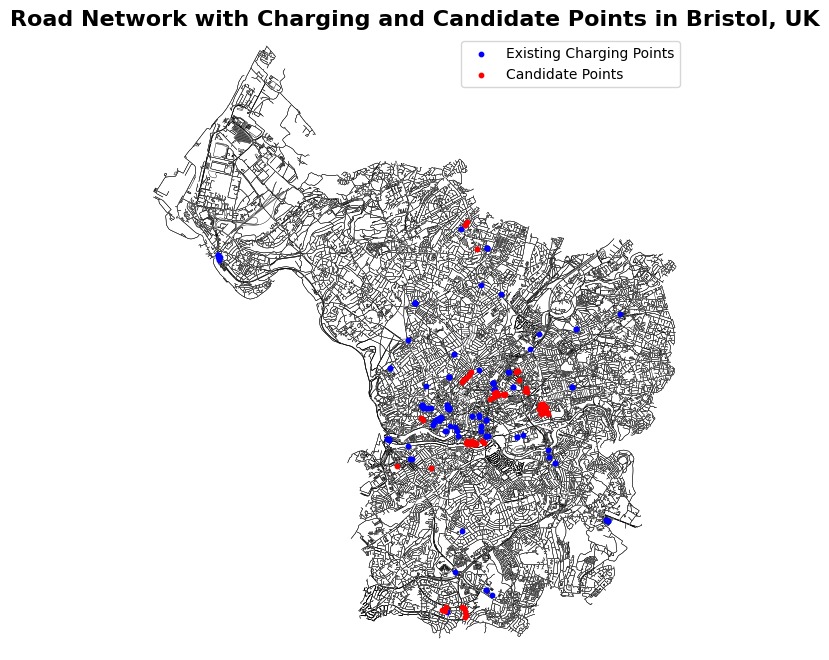

In [19]:
# Plot the road network
fig, ax = ox.plot_graph(
    bristol_road_network, 
    node_size=0.1, 
    edge_color='black', 
    edge_linewidth=0.3, 
    bgcolor='white',
    show=False,
    close=False
)

# Plot charging points
charging_points.plot(ax=ax, color='blue', markersize=10, label='Existing Charging Points')

# Plot parking points
parking_points.plot(ax=ax, color='red', markersize=10, label='Candidate Points')

# Add title and legend
ax.set_title("Road Network with Charging and Candidate Points in Bristol, UK", fontsize=16, fontweight='bold')
ax.legend()

# Display the plot
plt.show()

### Estimated Number of Electric Vehicles

In [20]:
# Calculate age group
pop["age_16_29"] = pop[[f"MALE{i}" for i in range(16, 30)] + [f"FEMALE{i}" for i in range(16, 30)]].sum(axis=1)
pop["age_30_49"] = pop[[f"MALE{i}" for i in range(30, 50)] + [f"FEMALE{i}" for i in range(30, 50)]].sum(axis=1)
pop["age_50_69"] = pop[[f"MALE{i}" for i in range(50, 70)] + [f"FEMALE{i}" for i in range(50, 70)]].sum(axis=1)
pop["age_over_70"] = pop[[f"MALE{i}" for i in range(70, 91)] + [f"FEMALE{i}" for i in range(70, 91)]].sum(axis=1)

# Verify the results
pop[["age_16_29", "age_30_49", "age_50_69", "age_over_70"]].head()

,age_16_29,age_30_49,age_50_69,age_over_70
0,84,111,62,15
1,149,138,62,13
2,167,165,71,22
3,130,122,44,2
4,159,140,91,15


In [21]:
# Get the multiplier value for each age group based on "hybrid" and "electric" ownership rates
ev_multiplier = (ev_ownership.loc[ev_ownership["per_type"] == "hybrid", ["age_16_29", "age_30_49", "age_50_69", "age_over_70"]].values +
                 ev_ownership.loc[ev_ownership["per_type"] == "electric", ["age_16_29", "age_30_49", "age_50_69", "age_over_70"]].values)

# Calculate "ev_owner"
pop["ev_owner"] = (
    (pop["age_16_29"] * ev_ownership.loc[ev_ownership["per_type"] == "car_owner", "age_16_29"].values[0]) * ev_multiplier[0, 0] +
    (pop["age_30_49"] * ev_ownership.loc[ev_ownership["per_type"] == "car_owner", "age_30_49"].values[0]) * ev_multiplier[0, 1] +
    (pop["age_50_69"] * ev_ownership.loc[ev_ownership["per_type"] == "car_owner", "age_50_69"].values[0]) * ev_multiplier[0, 2] +
    (pop["age_over_70"] * ev_ownership.loc[ev_ownership["per_type"] == "car_owner", "age_over_70"].values[0]) * ev_multiplier[0, 3]
)

# Verify the results
pop[["ev_owner"]].head()

,ev_owner
0,8.295
1,10.0908
2,11.9592
3,8.1292
4,11.665


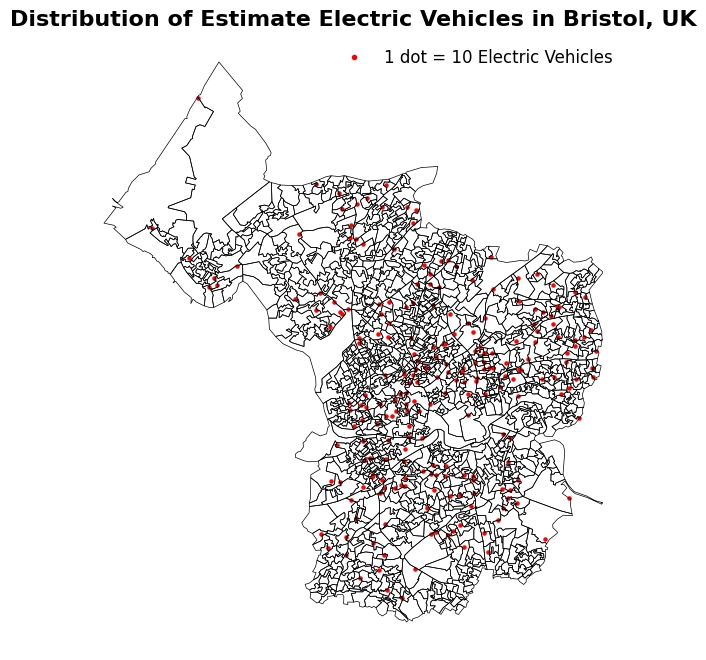

In [22]:
# Function to generate random points within a given polygon
def generate_random_points(polygon, num_points):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Scale down the number of dots
scale_dots = 10

# Generate random points for each area based on scaled 'ev_owner'
all_points = []
for _, row in pop.iterrows():
    num_dots = int(row['ev_owner'] / scale_dots)
    if num_dots > 0:
        random_points = generate_random_points(row['geometry'], num_dots)
        all_points.extend(random_points)

# Create a GeoDataFrame with the points
points_gdf = gpd.GeoDataFrame(geometry=all_points)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
points_gdf.plot(ax=ax, color='red', markersize=5, alpha=1.0)  # Plot the points
pop.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Plot polygon boundaries

# Set title and axis
ax.set_title("Distribution of Estimate Electric Vehicles in Bristol, UK", fontweight='bold', fontsize=16)
ax.set_axis_off()

# Adding a custom legend with f-string formatting
dot_size = 5  # Same as in the plot
legend_marker = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=dot_size)
ax.legend([legend_marker], [f'1 dot = {scale_dots} Electric Vehicles'], frameon=False, fontsize=12)

# Show the map
plt.show()

In [23]:
# Filter the gdf to keep only 'WARD_CODE_' and 'ev_owner' columns
pop_filtered = pop[['WARD_CODE_', 'ev_owner', 'geometry']]

# Group by 'WARD_CODE_' and summarize 'ev_owner' using sum
pop_merged = pop_filtered.dissolve(by='WARD_CODE_', aggfunc={'ev_owner': 'sum'})

# Reset index to make 'WARD_CODE_' a column again
pop = pop_merged.reset_index()

# Display the merged GeoDataFrame
pop

,WARD_CODE_,geometry,ev_owner
0,E05010885,"MULTIPOLYGON (((359033.187 173676.812, 359055....",486.0916
1,E05010886,"POLYGON ((352942.675 175904.515, 352712.723 17...",559.0314
2,E05010887,"POLYGON ((356066.187 170955.109, 356338.812 17...",334.2768
3,E05010888,"POLYGON ((359463.193 175087.404, 359348.321 17...",312.6848
4,E05010889,"POLYGON ((356750.674 168428.508, 356691.196 16...",322.4526
5,E05010890,"POLYGON ((362277.808 170322.568, 362175.345 17...",316.0746
6,E05010891,"POLYGON ((361619.921 170412.827, 361649.905 17...",314.5384
7,E05010892,"POLYGON ((358073.857 172167.688, 358273.404 17...",401.8192
8,E05010893,"POLYGON ((356721.352 172471.168, 356646.406 17...",314.1152
9,E05010894,"POLYGON ((357528.945 173364.044, 357500.719 17...",263.1502


### Filter for Population Who Drive to Work

In [24]:
# Filter the life style
life_style = life_style[(life_style["indicator"] == "% who drive to work") & (life_style["ward_code"].notna())]
life_style['drive_worker'] = life_style['statistic']
life_style

,FID,indicator_,indicator,theme,theme_indi,ward_code,ward_name,survey_que,sample_siz,statistic,standard_e,lower_conf,upper_conf,Shape__Are,Shape__Len,geometry,drive_worker
57,58,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010910,St George Central,Q17115,40,32.500000,7.387397,19.926212,48.229179,4.628189e+06,11350.420752,"POLYGON ((362472.721 173409.781, 362473.603 17...",32.500000
133,134,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010899,Frome Vale,Q17115,45,28.888889,6.818833,17.488961,43.777159,9.015775e+06,14857.917887,"POLYGON ((363003.801 177669.401, 363109.503 17...",28.888889
233,234,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010914,Southville,Q17115,90,18.888889,4.060838,12.166620,28.135572,4.401859e+06,13290.508540,"POLYGON ((357539.775 171339.613, 357535.603 17...",18.888889
253,254,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010912,St George West,Q17115,66,33.333333,5.919197,22.877867,45.733551,2.715954e+06,8161.632308,"POLYGON ((361815.350 174019.946, 361843.548 17...",33.333333
258,259,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010911,St George Troopers Hill,Q17115,38,57.894737,8.141719,41.673830,72.573397,3.445021e+06,10903.697388,"POLYGON ((362472.721 173409.781, 362485.088 17...",57.894737
486,487,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010918,Windmill Hill,Q17115,101,24.752475,4.246872,17.382442,33.962778,4.467580e+06,11951.501213,"POLYGON ((358028.064 170772.496, 358052.082 17...",24.752475
800,801,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010893,Clifton,Q17115,62,32.258065,5.914328,21.884444,44.733073,4.591388e+06,9887.729903,"POLYGON ((356991.453 174295.147, 356992.451 17...",32.258065
805,806,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010915,Stockwood,Q17115,48,70.833333,6.241792,57.325420,81.449186,8.337309e+06,13499.892964,"POLYGON ((360891.301 169997.048, 360905.466 17...",70.833333
896,897,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010904,Horfield,Q17115,60,43.333333,6.326064,31.578640,55.889437,5.894741e+06,10817.967333,"POLYGON ((359305.034 178446.029, 359305.504 17...",43.333333
1011,1012,IQOL17166,% who drive to work,Transport,Transport/% who drive to work,E05010916,Stoke Bishop,Q17115,47,51.063830,7.238618,37.163592,64.801478,1.476445e+07,17736.962202,"POLYGON ((354345.795 176330.175, 354515.453 17...",51.063830


In [25]:
# Merge the 'drive_worker' column from 'life_style' into 'pop' based on matching 'WARD_CODE_' and 'ward_code'
pop = pop.merge(life_style[['ward_code', 'drive_worker']], 
                left_on='WARD_CODE_', 
                right_on='ward_code', 
                how='left')

pop['ev_commute'] = pop['ev_owner'] * pop['drive_worker'] / 100

# Drop the extra 'ward_code' and 'drive_worker' columns after merging
pop = pop.drop(columns=['ward_code', 'drive_worker','ev_owner'])
pop

,WARD_CODE_,geometry,ev_commute
0,E05010885,"MULTIPOLYGON (((359033.187 173676.812, 359055....",95.687323
1,E05010886,"POLYGON ((352942.675 175904.515, 352712.723 17...",307.46727
2,E05010887,"POLYGON ((356066.187 170955.109, 356338.812 17...",108.286851
3,E05010888,"POLYGON ((359463.193 175087.404, 359348.321 17...",46.192073
4,E05010889,"POLYGON ((356750.674 168428.508, 356691.196 16...",170.7102
5,E05010890,"POLYGON ((362277.808 170322.568, 362175.345 17...",149.719548
6,E05010891,"POLYGON ((361619.921 170412.827, 361649.905 17...",113.037238
7,E05010892,"POLYGON ((358073.857 172167.688, 358273.404 17...",74.623566
8,E05010893,"POLYGON ((356721.352 172471.168, 356646.406 17...",101.327484
9,E05010894,"POLYGON ((357528.945 173364.044, 357500.719 17...",100.874243


## Part 2: Build ML Model

In [26]:
# Step 1: Prepare the Road Network

# If the road network is provided as a MultiDiGraph
if isinstance(bristol_road_network, nx.MultiDiGraph):
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(bristol_road_network)
else:
    # If `bristol_road_network` is not a MultiDiGraph, raise an error or split it into nodes and edges manually
    raise ValueError("The road network should be provided as a MultiDiGraph or separate node and edge GeoDataFrames.")

# Convert the GeoDataFrames to a graph
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

In [27]:
# Step 2: Calculate Distance Matrix between Population Areas and Charging/Candidate Points

# Utility function to convert Polygon or MultiPolygon geometries to their centroids
def convert_to_centroid(geometry):
    if geometry.geom_type in ['Polygon', 'MultiPolygon']:
        return geometry.centroid
    elif geometry.geom_type == 'Point':
        return geometry
    else:
        raise ValueError("Unsupported geometry type: Only Points, Polygons, and MultiPolygons are allowed.")
        
# Function to get the nearest node for a GeoDataFrame with point geometries
def get_nearest_node(gdf, graph):
    # Convert all geometries to centroids if they are Polygons or MultiPolygons
    gdf = gdf.copy()
    gdf['geometry'] = gdf['geometry'].apply(convert_to_centroid)
    
    # Ensure that all geometries are Points before calculating nearest nodes
    assert gdf.geometry.iloc[0].geom_type == 'Point', "All geometries must be Points after processing."
    
    # Calculate nearest node for each point in the gdf
    nodes = [ox.distance.nearest_nodes(graph, row.geometry.x, row.geometry.y) for _, row in gdf.iterrows()]
    return nodes

# Get the nearest nodes for population areas (use centroids), charging stations, and candidate points
pop['nearest_node'] = get_nearest_node(pop, G)
charging_points['nearest_node'] = get_nearest_node(charging_points, G)
parking_points['nearest_node'] = get_nearest_node(parking_points, G)

In [28]:
# Step 3: Define Surrogate Model Functions

# Function to create a training dataset by sampling demand-supply pairs
def create_training_data(demand_gdf, supply_gdf, graph, sample_fraction=0.1):
    np.random.seed(42)  # For reproducibility
    total_pairs = len(demand_gdf) * len(supply_gdf)  # Total number of demand-supply pairs
    sample_size = int(total_pairs * sample_fraction)  # Calculate sample size as a fraction of total pairs

    training_data = []

    # Convert demand and supply geometries to centroids if needed
    demand_gdf = demand_gdf.copy()
    supply_gdf = supply_gdf.copy()
    demand_gdf['geometry'] = demand_gdf['geometry'].apply(convert_to_centroid)
    supply_gdf['geometry'] = supply_gdf['geometry'].apply(convert_to_centroid)

    with tqdm(total=sample_size, desc="Generating Training Data", unit="pair") as pbar:
        for _ in range(sample_size):
            # Randomly select a demand and supply index
            demand_idx = np.random.choice(demand_gdf.index)
            supply_idx = np.random.choice(supply_gdf.index)
            
            # Get the nearest nodes for the selected pair
            source_node = demand_gdf.loc[demand_idx, 'nearest_node']
            target_node = supply_gdf.loc[supply_idx, 'nearest_node']
            
            # Calculate the distance and create feature vectors
            try:
                distance = nx.shortest_path_length(graph, source=source_node, target=target_node, weight='length')
                # Create feature vector: [demand_x, demand_y, supply_x, supply_y, straight_line_distance]
                demand_point = demand_gdf.loc[demand_idx, 'geometry']
                supply_point = supply_gdf.loc[supply_idx, 'geometry']
                straight_line_distance = demand_point.distance(supply_point)
                features = [demand_point.x, demand_point.y, supply_point.x, supply_point.y, straight_line_distance]
                training_data.append((features, distance))
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                continue

            # Update the progress bar after each iteration
            pbar.update(1)
    
    # Convert training data to arrays
    X_train = np.array([features for features, _ in training_data])
    y_train = np.array([distance for _, distance in training_data])
    
    return X_train, y_train

# Function to calculate the distance matrix using the surrogate model
def calculate_distance_matrix_ml(demand_gdf, supply_gdf, model):
    # Create an empty DataFrame to store distances
    distance_matrix = pd.DataFrame(index=demand_gdf.index, columns=supply_gdf.index)
    
    # Convert demand and supply geometries to centroids if needed
    demand_gdf = demand_gdf.copy()
    supply_gdf = supply_gdf.copy()
    demand_gdf['geometry'] = demand_gdf['geometry'].apply(convert_to_centroid)
    supply_gdf['geometry'] = supply_gdf['geometry'].apply(convert_to_centroid)

    # Create feature vectors for all pairs with a progress bar
    for demand_idx, demand_row in tqdm(demand_gdf.iterrows(), total=demand_gdf.shape[0], desc="Predicting Distances"):
        for supply_idx, supply_row in supply_gdf.iterrows():
            demand_point = demand_row['geometry']
            supply_point = supply_row['geometry']
            straight_line_distance = demand_point.distance(supply_point)
            
            # Create feature vector for prediction: [demand_x, demand_y, supply_x, supply_y, straight_line_distance]
            features = np.array([[demand_point.x, demand_point.y, supply_point.x, supply_point.y, straight_line_distance]])
            
            # Predict distance using the surrogate model
            predicted_distance = model.predict(features)[0]
            distance_matrix.loc[demand_idx, supply_idx] = predicted_distance
    
    return distance_matrix

In [29]:
# Step 4: Generate Training Data

print("Generating training data...")

# Use 10% of the total possible demand-supply pairs as the sample size
X_train, y_train = create_training_data(pop, parking_points, G, sample_fraction=0.1)

Generating training data...


Generating Training Data: 100%|████████████████████████████████████████████████████| 197/197 [00:17<00:00, 11.18pair/s]


In [30]:
# Step 5: Train the Surrogate Model

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
print("Training the Random Forest model...")

rf_model.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model...
Model training complete.


In [31]:
# Step 6: Use Surrogate Model to Predict Distance Matrices

print("Predicting Distance Matrix for Population to Existing Charging Stations using ML...")
distance_pop_to_charging_ml = calculate_distance_matrix_ml(pop, charging_points, rf_model)

print("Predicting Distance Matrix for Population to Candidate Points using ML...")
distance_pop_to_candidate_ml = calculate_distance_matrix_ml(pop, parking_points, rf_model)

Predicting Distance Matrix for Population to Existing Charging Stations using ML...


Predicting Distances: 100%|████████████████████████████████████████████████████████████| 34/34 [02:32<00:00,  4.50s/it]


Predicting Distance Matrix for Population to Candidate Points using ML...


Predicting Distances: 100%|████████████████████████████████████████████████████████████| 34/34 [01:03<00:00,  1.87s/it]


## Part 3: Build LP Model

In [32]:
# Step 1: Create the Optimization Model

# Define the problem
problem = LpProblem("Optimal_Charging_Station_Location", LpMinimize)

# Define Decision Variables
# Binary variable for selecting candidate points as new charging stations
x = LpVariable.dicts("Candidate_Selected", parking_points.index, cat=LpBinary)

# Binary assignment variable for assigning demand points to charging stations (existing or new)
y = LpVariable.dicts("Assignment", [(i, j) for i in pop.index for j in charging_points.index.union(parking_points.index)], cat=LpBinary)

In [33]:
# Step 2: Objective Function

# Calculate total distance from demand points to charging stations (existing and candidate)
total_weighted_distance = lpSum(
    pop.loc[i, 'ev_commute'] * distance_pop_to_charging_ml.loc[i, j] * y[(i, j)] for i in pop.index for j in charging_points.index
) + lpSum(
    pop.loc[i, 'ev_commute'] * distance_pop_to_candidate_ml.loc[i, j] * y[(i, j)] for i in pop.index for j in parking_points.index
)

# Set the objective
problem += total_weighted_distance, "Total Weighted Distance"

In [34]:
# Constraint 1: Each demand point must be assigned to exactly one charging station (existing or new)
for i in pop.index:
    constraint_name = f"Demand_Assignment_{i}_{uuid.uuid4()}"  # Generate a unique name using uuid
    problem += lpSum([y[(i, j)] for j in charging_points.index.union(parking_points.index)]) == 1, constraint_name
    
# Constraint 2: A demand point can only be assigned to a candidate station if that station is selected
for i in pop.index:
    for j in parking_points.index:
        constraint_name = f"Service_Constraint_{i}_{j}_{uuid.uuid4()}"
        problem += y[(i, j)] <= x[j], constraint_name

# Constraint 3: Limit the number of new stations that can be opened (e.g., set this to a specific number if required)
max_new_stations = 1  # Change this value as needed
problem += lpSum([x[j] for j in parking_points.index]) <= max_new_stations, "Max_New_Stations"

In [35]:
# Step 3: Solve the Problem

print("Solving the optimization problem...")
problem.solve()

Solving the optimization problem...


1

In [36]:
# Step 4: Output and Interpretation

# Check the status of the solution
print(f"Solution Status: {LpStatus[problem.status]}")

# Get the selected candidate points
selected_candidates = [j for j in parking_points.index if x[j].varValue > 0.5]
print(f"Selected Candidate Points for New Charging Stations: {selected_candidates}")

Solution Status: Optimal
Selected Candidate Points for New Charging Stations: [33]


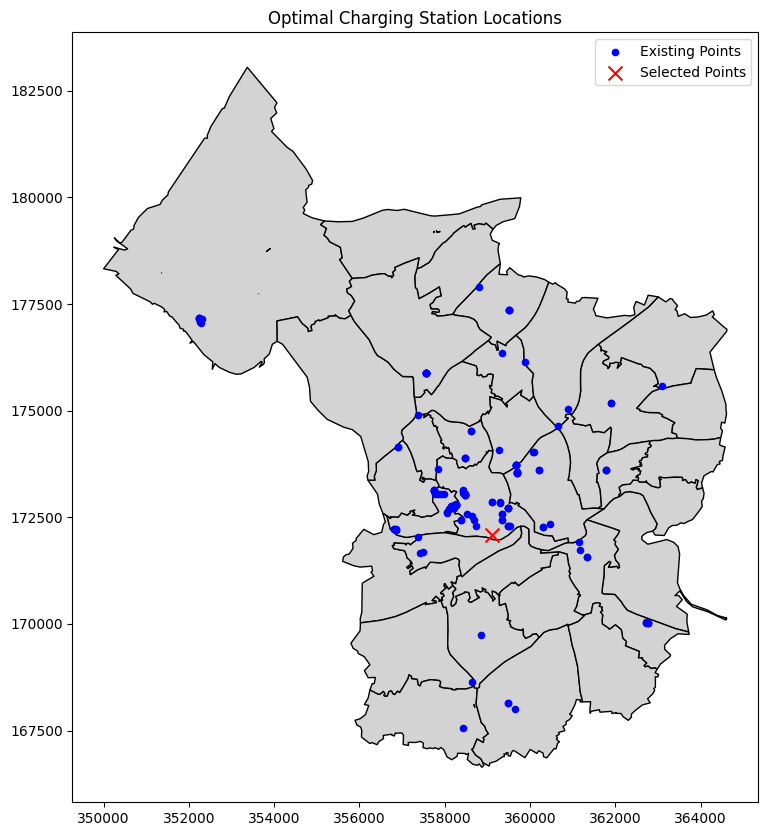

In [37]:
# Plot the population areas, existing charging stations, and selected candidate points
base = pop.plot(color='lightgrey', figsize=(10, 10), edgecolor='black')
charging_points.plot(ax=base, marker='o', color='blue', markersize=20, label='Existing Points')
parking_points[parking_points.index.isin(selected_candidates)].plot(ax=base, marker='x', color='red', markersize=100, label='Selected Points')
plt.legend()
plt.title('Optimal Charging Station Locations')

plt.show()

## Part 4: Sensitivity Analysis

In [38]:
# Function to run the optimization problem using the number of electric vehicles used for commuting ('ev_commute')
def run_optimization_with_commute_demand(commute_demand_adjustment=None, max_new_stations=1):
    """
    Run the optimization problem using the number of electric vehicles used for commuting ('ev_commute')
    as the demand weight.
    
    Parameters:
    - commute_demand_adjustment (dict): A dictionary where keys are demand point indices and values are the weight adjustments.
    - max_new_stations (int): Maximum number of new stations that can be added.
    
    Returns:
    - selected_candidates: The selected candidate points.
    - total_weighted_distance: The total weighted distance of the solution.
    """
    # Create a copy of the commuting weights
    commute_weights = pop['ev_commute'].copy()
    
    # Apply commute demand adjustments if provided
    if commute_demand_adjustment:
        for i, adjustment in commute_demand_adjustment.items():
            commute_weights.loc[i] = adjustment

    # Define the problem
    problem = LpProblem("Optimal_Charging_Station_Location_with_Commute_Demand", LpMinimize)
    
    # Define Decision Variables
    x = LpVariable.dicts("Candidate_Selected", parking_points.index, cat=LpBinary)
    y = LpVariable.dicts("Assignment", [(i, j) for i in pop.index for j in charging_points.index.union(parking_points.index)], cat=LpBinary)
    
    # Objective Function: Minimize total weighted distance using 'ev_commute'
    total_weighted_distance = lpSum(
        commute_weights[i] * distance_pop_to_charging_ml.loc[i, j] * y[(i, j)] for i in pop.index for j in charging_points.index
    ) + lpSum(
        commute_weights[i] * distance_pop_to_candidate_ml.loc[i, j] * y[(i, j)] for i in pop.index for j in parking_points.index
    )
    problem += total_weighted_distance, "Total Weighted Distance with Commute Demand"
    
    # Constraints
    for i in pop.index:
        problem += lpSum([y[(i, j)] for j in charging_points.index.union(parking_points.index)]) == 1, f"Demand_Assignment_{i}"

    for i in pop.index:
        for j in parking_points.index:
            problem += y[(i, j)] <= x[j], f"Service_Constraint_Demand_{i}_Candidate_{j}"

    # Constraint: Limit the number of new stations
    problem += lpSum([x[j] for j in parking_points.index]) <= max_new_stations, "Max_New_Stations"
    
    # Solve the problem
    problem.solve()
    
    # Get selected candidate points
    selected_candidates = [j for j in parking_points.index if x[j].varValue > 0.5]
    
    return selected_candidates, problem.objective.value()

In [39]:
# Sensitivity Analysis: Varying Commute Demand Weights
sensitivity_results = {}
adjustment_factors = [0.8, 1.0, 1.2]  # Factors to increase or decrease 'ev_commute' by 20%

# Iterate through each adjustment factor
for factor in adjustment_factors:
    print(f"Running sensitivity analysis with adjustment factor: {factor}...")
    
    # Apply the adjustment factor to all demand points
    commute_demand_adjustment = {i: pop.loc[i, 'ev_commute'] * factor for i in pop.index}
    
    # Run the optimization with adjusted commute demand
    selected_candidates, total_distance = run_optimization_with_commute_demand(commute_demand_adjustment=commute_demand_adjustment, max_new_stations=1)
    
    # Store the results for the current scenario
    sensitivity_results[f"Commute_Adjustment_{factor}"] = {
        "Selected Candidates": selected_candidates,
        "Total Weighted Distance": total_distance
    }

# Create a table to display the sensitivity results
sensitivity_df = pd.DataFrame({
    "Scenario": list(sensitivity_results.keys()),
    "Selected Candidates": [results["Selected Candidates"] for results in sensitivity_results.values()],
    "Total Weighted Distance": [results["Total Weighted Distance"] for results in sensitivity_results.values()]
})

# Display the table using IPython display function
display(sensitivity_df)

Running sensitivity analysis with adjustment factor: 0.8...
Running sensitivity analysis with adjustment factor: 1.0...
Running sensitivity analysis with adjustment factor: 1.2...


,Scenario,Selected Candidates,Total Weighted Distance
0,Commute_Adjustment_0.8,[33],5.865836e+06
1,Commute_Adjustment_1.0,[33],7.332295e+06
2,Commute_Adjustment_1.2,[33],8.798754e+06
